In [1]:
# Let's import the needed packages
# To deal with arrays 
import xarray as xr
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np

# To plot curves
import matplotlib.pyplot as plt
import seaborn as sns

# To plot the map
import cartopy.crs as ccrs

# Importing Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Prediction Scores
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dimensionality reduction 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#import our useful functions 
import useful_functions

# One-month prediction of El Nino Events

In [101]:
# Get the data for a 1-month prediction
X, y = useful_functions.get_data("data/preprocessed_data/nino_dataset_1m.npz")

==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]


The problem here is that we have a small amount of data and the data are in high dimension. 
**=> High risk of overfitting**

Let us try to first simple model so we can have a baseline.

## 1. Baseline - LDA

In this part, we explore a simple model, to have a first prediction score and then decide guideines for the rest of our work.

### 1.1 First evaluation

In [102]:
X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374)

# Define the classifier
lda = LinearDiscriminantAnalysis()

# Fit the model on the data
lda.fit(X_train,y_train)

# Get the prediction
y_test_pred = lda.predict(X_test)
y_train_pred = lda.predict(X_train)

# Computation of the AUC and accuracy
roc_auc_score_lda_train = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
accuracy_score_lda_train = accuracy_score(y_train, y_train_pred)

roc_auc_score_lda_test = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
accuracy_score_lda_test = accuracy_score(y_test, y_test_pred)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {accuracy_score_lda_train:.3f}")
print(f"     AUC for TRAIN data: {roc_auc_score_lda_train:.3f}")

print("==== TEST ====")
print(f"Accuracy for TEST data: {accuracy_score_lda_test:.3f}")
print(f"     AUC for TEST data: {roc_auc_score_lda_test:.3f}")


==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== TRAIN ====
Accuracy for TRAIN data: 0.984
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.860
     AUC for TEST data: 0.947


Overfitting !!!
Before trying this model, we will try to reduce the overfitting by performing dimensionality reduction.

### 1.2 Dimensionality reduction: PCA

Text(0.5, 1.0, 'Cumulative Explained Variance by Principal Components')

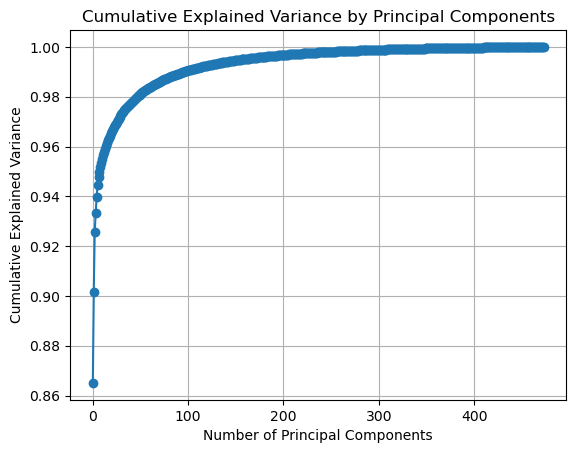

In [103]:
# PCA
PCA_sst = PCA(n_components = None)
PCA_sst.fit(X)

# Computation of the explained variance ratio
explained_variance_ratio_sst = PCA_sst.explained_variance_ratio_

# Plot of the explained variance ratio
plt.grid()
plt.plot(np.cumsum(explained_variance_ratio_sst), marker = 'o')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')

In [104]:
# Perform several LDA with different value of p to get a validation curve for this parameter
p_values = np.linspace(1, 100, 100).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components = p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
        Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
        )

    # Define the classifier
    lda = LinearDiscriminantAnalysis()

    # Fit the model on the data
    lda.fit(X_train,y_train)

    # Get the prediction
    y_test_pred= lda.predict(X_test)
    y_train_pred= lda.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred))


In [105]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")
print(f"Test score improvement: + {best_test_score_pca - accuracy_score_lda_test:.2f}")

Best value of p - PCA : 55
Train Score for the best p: 0.9385026737967914
Test Score for the best p: 0.93
Test score improvement: + 0.07


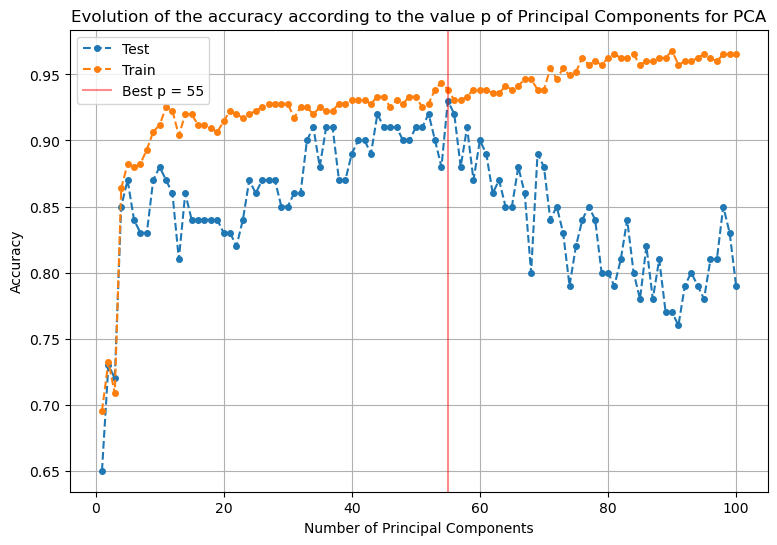

In [106]:
# Plot the validation curve
plt.figure(figsize = [9,6])
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Train accuracy with the best p: 0.93
Train AUC with the best p: 0.98
Test accuracy with the best p: 0.91
Test auc with the best p: 0.96


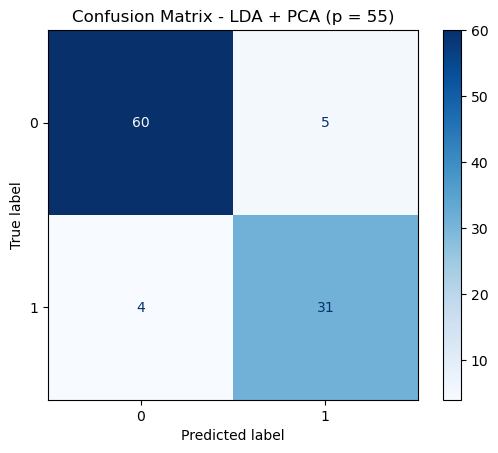

In [107]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

# Make predictions 
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_test_pred = lda.predict(X_test)
y_train_pred = lda.predict(X_train)

# Compute the scores 
train_accuracy_LDA = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_LDA = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
print(f"Train accuracy with the best p: {train_accuracy_LDA:.2f}")
print(f"Train AUC with the best p: {roc_auc_score_train_LDA:.2f}")

test_accuracy_LDA = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_LDA = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy_LDA:.2f}")
print(f"Test auc with the best p: {roc_auc_score_test_LDA:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lda.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - LDA + PCA (p = {best_p_value})")
plt.show()

## 2. Ridge and Lasso for classification task

In this part, we explore the use of Ridge and Lasso Regressions for the classification task, as we want to perform regularization to prevent overfitting.

In [ ]:
# We work with the original data and split it 
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    X, y, RANDOM_SPLIT=False, train_size=374
    )

X_train_cv, X_validation, y_train_cv, y_validation = useful_functions.split_scale_data(
    X_train, y_train, RANDOM_SPLIT=False, train_size=300, scale= False
    )

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (300, 64800)
Shape of y_train: (300,)
Shape of X_test: (74, 64800)
Shape of y_test: (74,)


### 2.1 Ridge Classification 

In [5]:
# Define and evaluate the Ridge classifier on the original training and test data
ridge = RidgeClassifier(alpha = 1.0)  # Default hyperparameter
ridge.fit(X_train, y_train)

print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {ridge.score(X_train, y_train):.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {ridge.score(X_test, y_test):.3f}")


==== TRAIN ====
Accuracy for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.850


c:\Users\natha\anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\_ridge.py:248: LinAlgWarning: Ill-conditioned matrix (rcond=4.76494e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


In [15]:
best_lambda, max_accuracy_validation_Ridge, train_accuracy_Ridge, lambda_values, coefficients, accuracy_train_cv_list, accuracy_valid_list = useful_functions.validation(X_train_cv,
                                                                                           y_train_cv,
                                                                                           X_validation,
                                                                                           y_validation,
                                                                                           low_power=1,
                                                                                           high_power=7,
                                                                                           nb_points=100)


Best parameter value after validation: 16297.5
Accuracy for training: 0.983
Accuracy for validation: 0.932


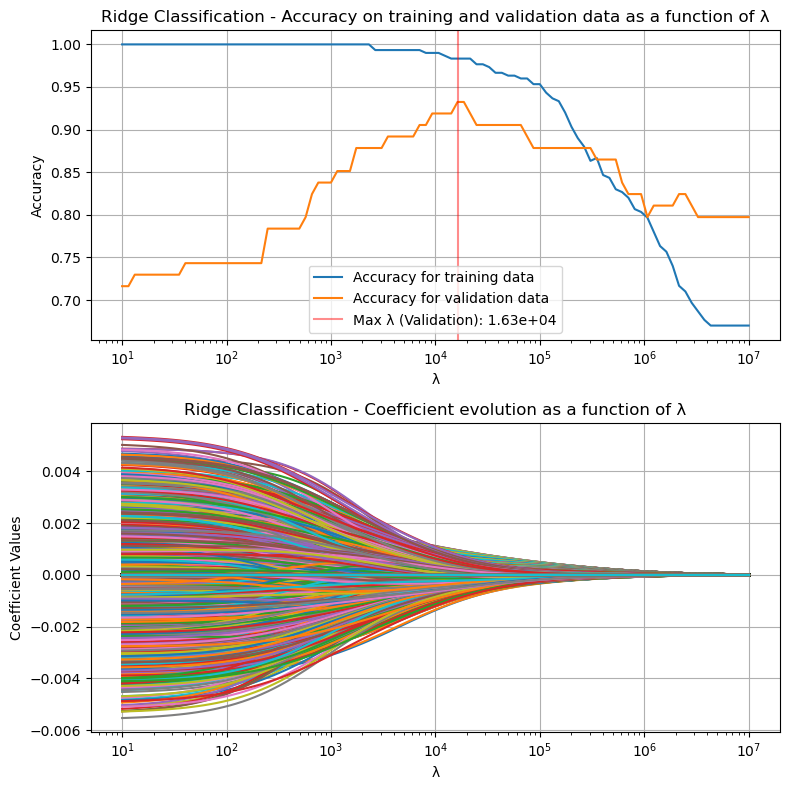

In [16]:
# Plot accuracy and coefficient evolution as a function of lambda
plt.figure(figsize = [8, 8])

# Plot accuracy for training and validation sets
plt.subplot(2, 1, 1)
plt.semilogx(lambda_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(lambda_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = best_lambda, color = 'r', linestyle = '-', label = f'Max λ (Validation): {best_lambda:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.title('Ridge Classification - Accuracy on training and validation data as a function of λ')
plt.grid()

# Plot coefficient evolution
plt.subplot(2, 1, 2)
plt.semilogx(lambda_values, coefficients[:, 0])
plt.xlabel('λ')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Ridge Classification - Coefficient evolution as a function of λ')

plt.tight_layout()
plt.show()

Train accuracy with the best λ: 0.98
Train AUC with the best λ: 1.00
Test accuracy with the best λ: 0.91
Test AUC with the best λ: 0.96


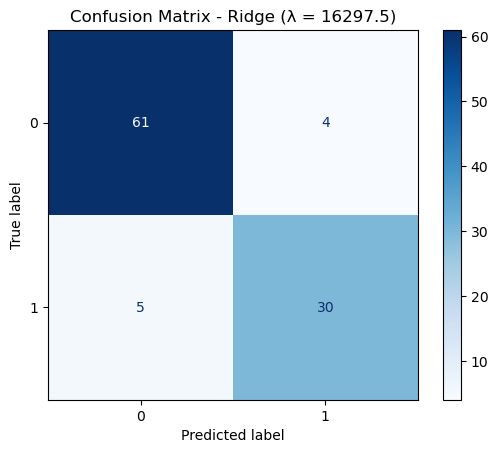

In [17]:
# Evaluate the best Ridge model
ridge = RidgeClassifier(alpha = best_lambda)
ridge.fit(X_train, y_train)

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

# Decision values for AUC computation
train_decision_values = ridge.decision_function(X_train)
test_decision_values = ridge.decision_function(X_test)

# Compute scores
train_accuracy_RIDGE = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_RIDGE = roc_auc_score(y_train, train_decision_values)
print(f"Train accuracy with the best λ: {train_accuracy_RIDGE:.2f}")
print(f"Train AUC with the best λ: {roc_auc_score_train_RIDGE:.2f}")

test_accuracy_RIDGE = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_RIDGE = roc_auc_score(y_test, test_decision_values)
print(f"Test accuracy with the best λ: {test_accuracy_RIDGE:.2f}")
print(f"Test AUC with the best λ: {roc_auc_score_test_RIDGE:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ridge.classes_)
disp.plot(cmap = 'Blues')
plt.title(f"Confusion Matrix - Ridge (λ = {best_lambda:.1f})")
plt.show()

### 2.2 Lasso Classification

In this part, we will use the Lasso algorithm to perform a regularization of our model, trying to prevent overfitting. As there is no "LassoClassifier" function, we will use the LogisticRegression function with penalty parameter set to "l1".

In [18]:
# Define the classifier
lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1.0) 
lasso.fit(X_train, y_train)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {lasso.score(X_train, y_train):.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {lasso.score(X_test, y_test):.3f}")

==== TRAIN ====
Accuracy for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.880


In [19]:
best_C, max_accuracy_validation_Lasso, train_accuracy_Lasso, C_values, coefficients, accuracy_train_cv_list, accuracy_valid_list = useful_functions.validation(X_train_cv,
                                                                                           y_train_cv,
                                                                                           X_validation,
                                                                                           y_validation,
                                                                                           low_power=-3,
                                                                                           high_power=2,
                                                                                           nb_points=50,
                                                                                           Ridge=False)


Best parameter value after validation: 0.1
Accuracy for training: 0.937
Accuracy for validation: 0.932


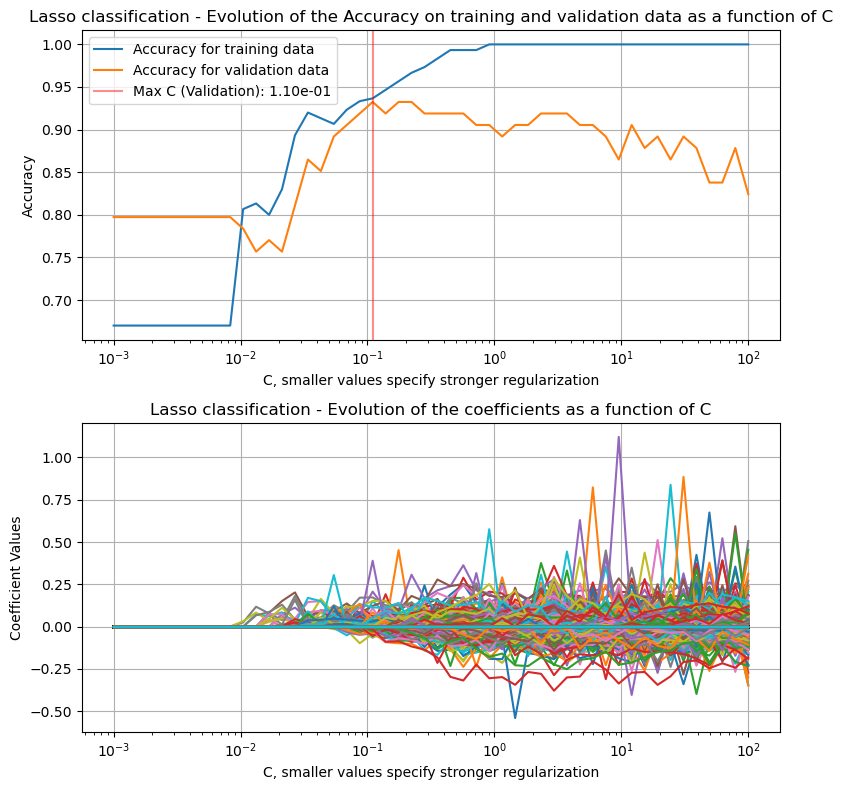

In [21]:
# Plot the results
plt.figure(figsize = [8,8])
plt.subplot(2,1,1)

plt.semilogx(C_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(C_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = best_C, color = 'r', linestyle = '-', label = f'Max C (Validation): {best_C:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Accuracy')
plt.title('Lasso classification - Evolution of the Accuracy on training and validation data as a function of C')
plt.grid()

plt.subplot(2,1,2)
plt.semilogx(C_values, coefficients[:, 0])
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Lasso classification - Evolution of the coefficients as a function of C')

plt.tight_layout() 

Train accuracy with the best λ: 0.94
Train AUC with the best λ: 0.98
Test accuracy with the best λ: 0.88
Test auc with the best λ: 0.97


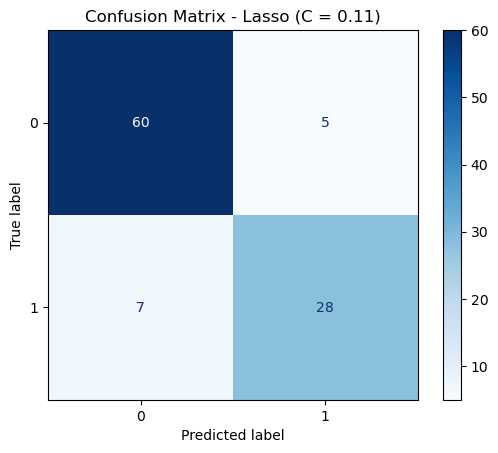

In [23]:
# Evaluate the best Lasso model
lasso = LogisticRegression(penalty='l1', solver='liblinear', C = best_C)
lasso.fit(X_train, y_train)

y_test_pred = lasso.predict(X_test)
y_train_pred = lasso.predict(X_train)

train_decision_values = lasso.decision_function(X_train)
test_decision_values = lasso.decision_function(X_test)

# Compute the scores 
train_accuracy_LASSO = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_LASSO = roc_auc_score(y_train, train_decision_values)
print(f"Train accuracy with the best λ: {train_accuracy_LASSO:.2f}")
print(f"Train AUC with the best λ: {roc_auc_score_train_LASSO:.2f}")

test_accuracy_LASSO = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_LASSO = roc_auc_score(y_test, test_decision_values)
print(f"Test accuracy with the best λ: {test_accuracy_LASSO:.2f}")
print(f"Test auc with the best λ: {roc_auc_score_test_LASSO:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, lasso.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = lasso.classes_)
disp.plot(cmap = 'Blues')
plt.title(f"Confusion Matrix - Lasso (C = {best_C:.2f})")
plt.show()

## 3. Test Different Models

In this part, we want to do hyper-parameter tuning for different chosen models. However we have a lot of features and probably some of them are correlated which can prevent the models to perform properly. Here we perform a PCA, keeping 50 features, as the cumulative explained variance for 50 features is around 98% (see graph of the begining of the notebook). With this dimensionality reduction, we test the models to see which one is the better and then we select the best one and perform more precisely PCA, to see with which dimensions it performs the best.

In [57]:
# Define PCA for 50 features 
PCA_sst = PCA(n_components = 50)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

In [58]:
# param grid for hyper-parameter tuning
qda_params = {'reg_param': [0, 0.1, 0.2, 0.5, 0.7, 0.9]}
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
param_grids = [qda_params, rf_params, svc_params, gb_params]

models = [QuadraticDiscriminantAnalysis(), RandomForestClassifier(), SVC(probability=True), GradientBoostingClassifier()]
model_names = ["QDA", "RandomForestClassifier", "SVC", "GradientBoostingClassifier"]

best_model_name = None
best_model = None
best_params = None
best_accuracy = 0
best_auc = 0

models_accuracies = []
models_auc = []

for i in range(len(models)):
    print(f"\nTuning {model_names[i]}")
    grid_search = GridSearchCV(models[i], param_grids[i], scoring = 'accuracy', cv = 5)
    grid_search.fit(X_train, y_train)

    # Best estimator and parameters
    best_estimator = grid_search.best_estimator_
    best_params_model = grid_search.best_params_
    best_accuracy_model = grid_search.best_score_

    # Evaluate on the test set
    y_test_pred = best_estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, best_estimator.predict_proba(X_test)[:, 1])

    print(f"Best Parameters for {model_names[i]}: {best_params_model}")
    print(f"Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")

    models_accuracies.append(test_accuracy)
    models_auc.append(test_auc)

    if test_accuracy > best_accuracy or (test_accuracy == best_accuracy and test_auc > best_auc):
        best_model_name = model_names[i]
        best_model = best_estimator
        best_params = best_params_model
        best_accuracy = test_accuracy
        best_auc = test_auc

print(f"\nBest Model: {best_model_name}")
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best AUC: {best_auc:.4f}")


Tuning QDA
Best Parameters for QDA: {'reg_param': 0.9}
Test Accuracy: 0.8200, Test AUC: 0.9455

Tuning RandomForestClassifier
Best Parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 100}
Test Accuracy: 0.8700, Test AUC: 0.9477

Tuning SVC
Best Parameters for SVC: {'C': 0.1, 'kernel': 'linear'}
Test Accuracy: 0.8600, Test AUC: 0.9613

Tuning GradientBoostingClassifier
Best Parameters for GradientBoostingClassifier: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Test Accuracy: 0.8600, Test AUC: 0.9371

Best Model: RandomForestClassifier
Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Best Accuracy: 0.8700
Best AUC: 0.9477


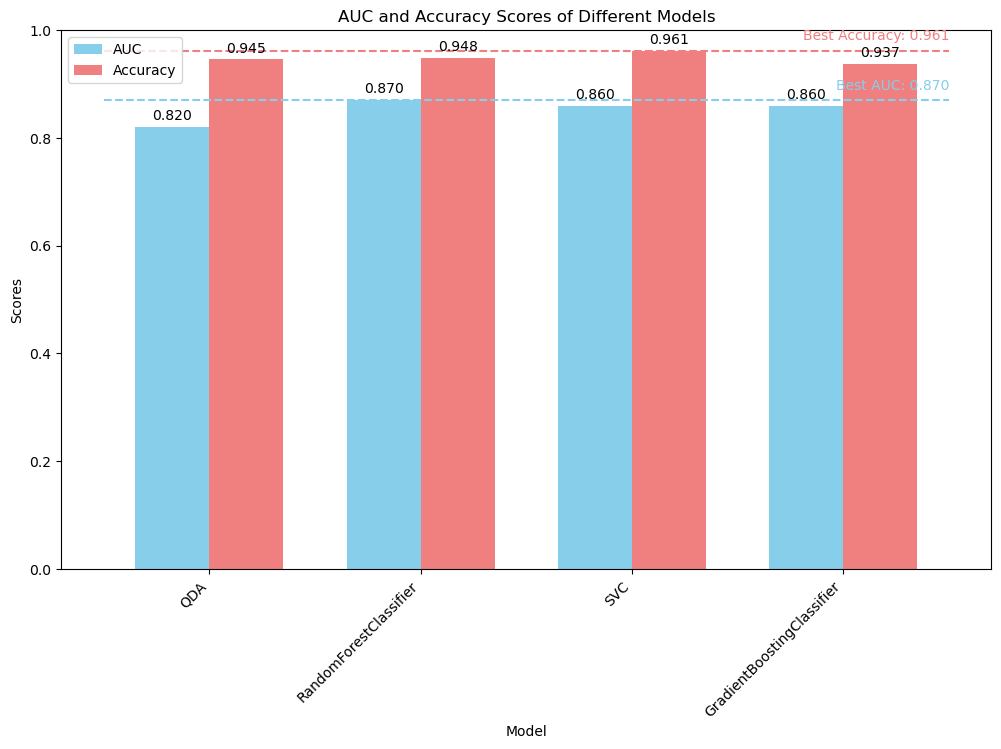

In [59]:
def plot_score(model_names, auc_scores, accuracy_scores):
    x = np.arange(len(model_names))
    fig, ax = plt.subplots(figsize = (12, 7))

    #plot the histograms of accuracy and auc 
    auc_bars = ax.bar(x - 0.175, auc_scores, 0.35, label = 'AUC', color = 'skyblue')
    accuracy_bars = ax.bar(x + 0.175, accuracy_scores, 0.35, label = 'Accuracy', color = 'lightcoral')

    #plot horizontal lines for the highest accuracy and auc
    max_auc = max(auc_scores)
    max_accuracy = max(accuracy_scores)
    ax.hlines(y = max_auc, xmin = -0.5, xmax = len(model_names)-0.5, colors = 'skyblue', linestyles = '--', linewidth = 1.5) 
    ax.hlines(y = max_accuracy, xmin = -0.5, xmax = len(model_names)-0.5, colors = 'lightcoral', linestyles = '--', linewidth = 1.5)  
    ax.text(len(model_names)-0.5, max_auc + 0.02, f'Best AUC: {max_auc:.3f}', color='skyblue', ha='right')
    ax.text(len(model_names)-0.5, max_accuracy + 0.02, f'Best Accuracy: {max_accuracy:.3f}', color='lightcoral', ha='right')

    ax.set_xlabel('Model')
    ax.set_ylabel('Scores')
    ax.set_ylim(0, 1)
    ax.set_title('AUC and Accuracy Scores of Different Models')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation = 45, ha = 'right')
    ax.set_xticklabels(model_names)
    ax.legend()

    #annotations for the value of each bar
    for bar in auc_bars + accuracy_bars:
        ax.annotate(f'{bar.get_height():.3f}', 
                    xy = (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                    xytext = (0, 3), 
                    textcoords = "offset points",
                    ha = 'center', va = 'bottom')

    plt.show()

plot_score(model_names, models_accuracies, models_auc)

### Test the Best Model 

In [60]:
p_values = np.linspace(1, 50, 50).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []
models_pca = []

for p in p_values:
    PCA_sst = PCA(n_components = p)
    PCA_sst.fit(X)

    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

    # Define the classifier
    model = best_model

    # Fit the model on the data
    model.fit(X_train,y_train)

    # Get the prediction
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred))
    models_pca.append(model)

In [61]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]
best_model_pca = models_pca[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")

Best value of p - PCA : 17
Train Score for the best p: 1.0
Test Score for the best p: 0.93


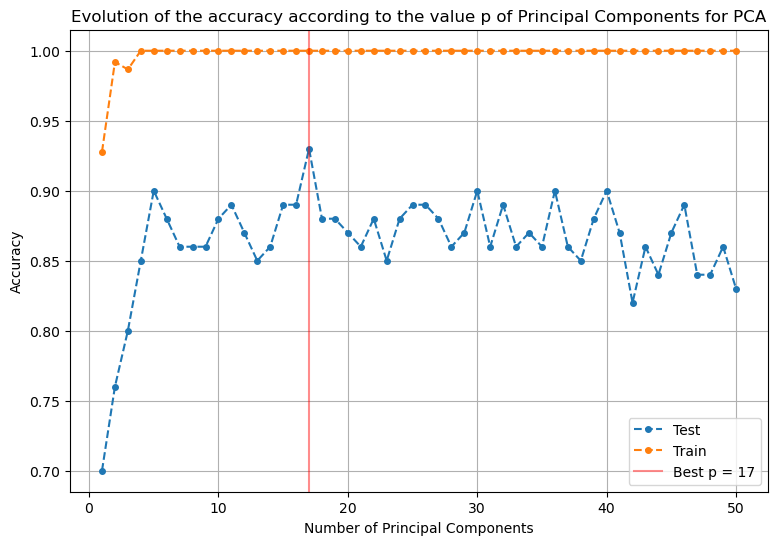

In [62]:
# Plot the validation curve
plt.figure(figsize = [9,6])
plt.plot(p_values, test_score_accuracy, 'o', markersize = 4, ls = '--', label = "Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize = 4, ls = '--', label = "Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Test accuracy with the best p: 1.00
Test auc with the best p: 1.00
Test accuracy with the best p: 0.89
Test auc with the best p: 0.95


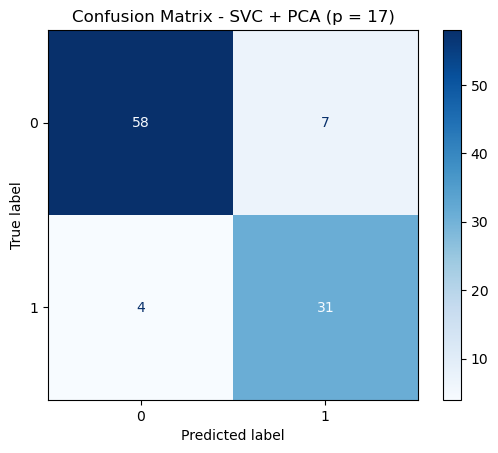

In [63]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
)
best_model_pca.fit(X_train, y_train)

# Make predictions 
y_test_pred = best_model_pca.predict(X_test)
y_train_pred = best_model_pca.predict(X_train)

# Print the scores
train_accuracy_SVC = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_SVC = roc_auc_score(y_train, best_model_pca.predict_proba(X_train)[:, 1])
print(f"Test accuracy with the best p: {train_accuracy_SVC:.2f}")
print(f"Test auc with the best p: {roc_auc_score_train_SVC:.2f}")

test_accuracy_SVC = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_SVC = roc_auc_score(y_test, best_model_pca.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy_SVC:.2f}")
print(f"Test auc with the best p: {roc_auc_score_test_SVC:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = best_model_pca.classes_)
disp.plot(cmap = 'Blues')
plt.title(f"Confusion Matrix - SVC + PCA (p = {best_p_value})")
plt.show()

## 4. Neural Networks 

Let's try to use Neural Networks for now. We are going to project the data on 50 features and do our hyper-parameter tuning (just like in part 3) and then we will select the best model and tune the best p for the PCA.

In [87]:
# Define PCA for 50 features 
PCA_sst = PCA(n_components = 50)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
    )

In [88]:
param_grid = {
    'hidden_layer_sizes': [
        (128,),              
        (128, 64),           
        (128, 64, 32),       
        (256, 128, 64),      
    ],
    'alpha': [1e-4, 1e-3, 1e-2],  
    'solver': ['adam'],           
    'max_iter': [200],            
}

mlp = MLPClassifier(random_state = 42, early_stopping = True, validation_fraction = 0.2)

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
grid_search = GridSearchCV(estimator=mlp, param_grid = param_grid, scoring = 'accuracy', cv = cv)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validated accuracy: {grid_search.best_score_:.3f}")

Best parameters found: {'alpha': 0.0001, 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 200, 'solver': 'adam'}
Best cross-validated accuracy: 0.904


In [89]:
# Validation curve with different values of p for the MLP model
p_values = np.linspace(1, 50, 50).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []
models_pca = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components=p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
        Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
        )

    # Define the classifier
    model = grid_search.best_estimator_

    # Fit the model on the data
    model.fit(X_train,y_train)

    # Get the prediction
    y_test_pred= model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred))
    models_pca.append(model)


In [90]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]
best_model_pca = models_pca[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")

Best value of p - PCA : 33
Train Score for the best p: 0.9812834224598931
Test Score for the best p: 0.9


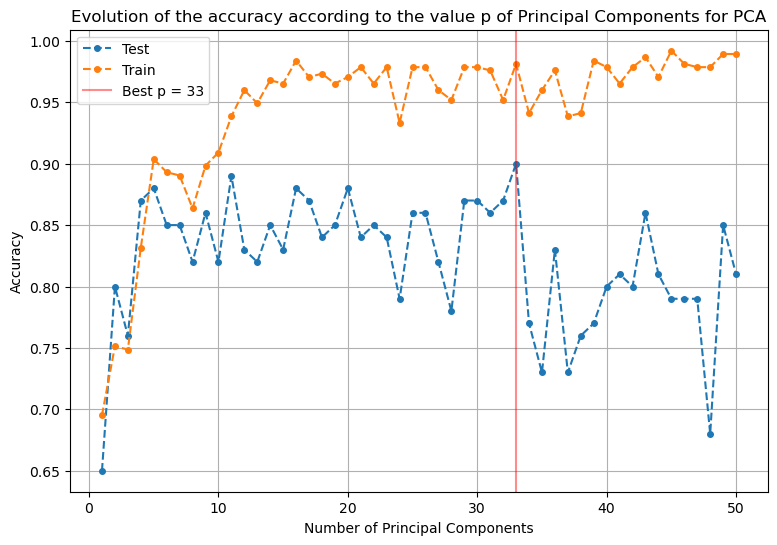

In [91]:
# Plot the validation curve
plt.figure(figsize = [9,6])
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Test accuracy with the best p: 0.97
Test auc with the best p: 0.99
Test accuracy with the best p: 0.83
Test auc with the best p: 0.95


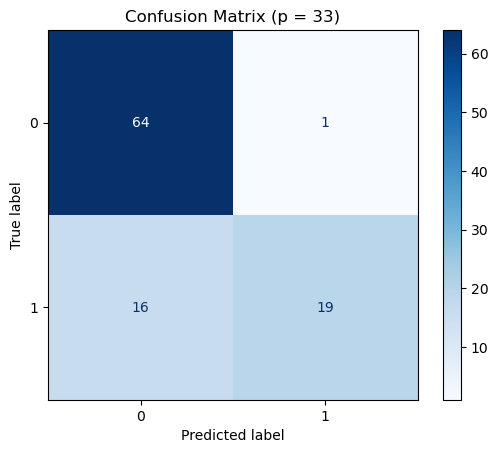

In [92]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
)
best_model_pca.fit(X_train, y_train)

# Make predictions 
y_test_pred = best_model_pca.predict(X_test)
y_train_pred = best_model_pca.predict(X_train)

# Print the scores
train_accuracy_MLP = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_MLP = roc_auc_score(y_train, best_model_pca.predict_proba(X_train)[:, 1])
print(f"Test accuracy with the best p: {train_accuracy_MLP:.2f}")
print(f"Test auc with the best p: {roc_auc_score_train_MLP:.2f}")

# Print the scores
test_accuracy_MLP = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_MLP = roc_auc_score(y_test, best_model_pca.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy_MLP:.2f}")
print(f"Test auc with the best p: {roc_auc_score_test_MLP:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = best_model_pca.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (p = {best_p_value})")
plt.show()

## 5. Recap of the Models

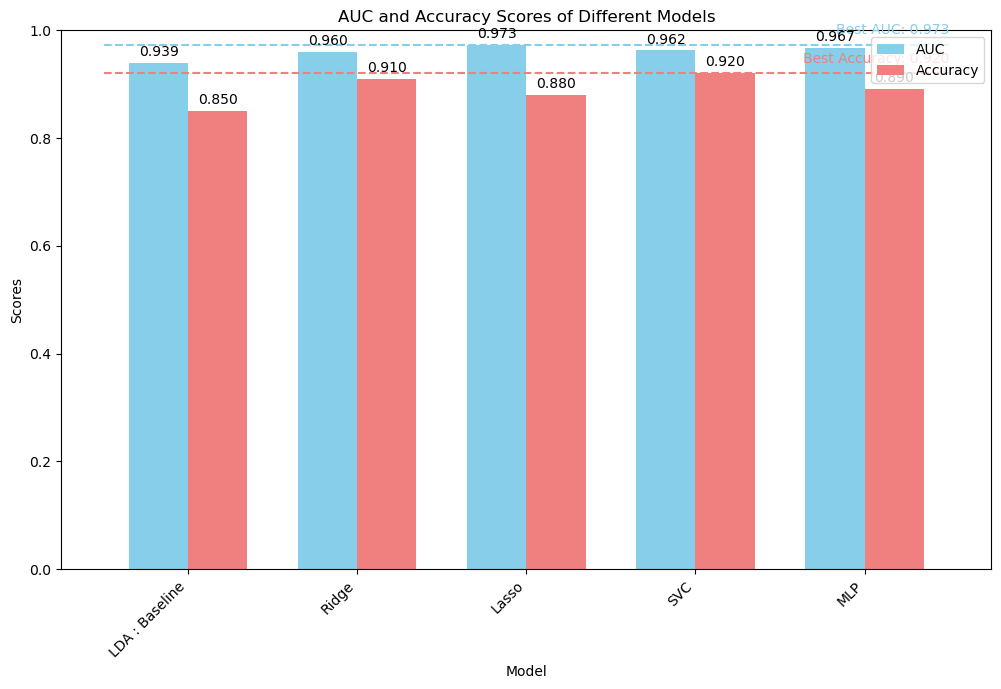

In [37]:
model_names = ["LDA : Baseline", "Ridge", "Lasso", "SVC", "MLP"]
models_accuracies = [test_accuracy_LDA, test_accuracy_RIDGE, test_accuracy_LASSO, test_accuracy_SVC, test_accuracy_MLP]
models_auc = [roc_auc_score_test_LDA, roc_auc_score_test_RIDGE, roc_auc_score_test_LASSO, roc_auc_score_test_SVC, roc_auc_score_test_MLP]
plot_score(model_names, models_auc, models_accuracies)

For a 1-month prediction, the best model we manage to get is SVC.

# Two-month prediction of El Niño Events

In this part, we will apply the 5 five models tested before and see if the results change as the prediction is for 2 months.

In [24]:
# Get the data for a 2-month prediction, split and scale the data
X2, y2 = useful_functions.get_data("data/preprocessed_data/nino_dataset_2m.npz")

==== GET THE DATA ====
Shape of X: (473, 64800)
Shape of y: (473,)
First 25 elements of y: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]


## 1. LDA

In [25]:
X2_train, X2_test, y2_train, y2_test= useful_functions.split_scale_data(X2, y2, RANDOM_SPLIT = False, train_size = 373)

# Define the classifier
lda2 = LinearDiscriminantAnalysis()

# Fit the model on the data
lda2.fit(X2_train,y2_train)

# Get the prediction
y2_test_pred = lda2.predict(X2_test)
y2_train_pred = lda2.predict(X2_train)

# Computation of the AUC and accuracy
roc_auc_score_lda_train = roc_auc_score(y2_train, lda2.predict_proba(X2_train)[:, 1])
accuracy_score_lda_train = accuracy_score(y2_train, y2_train_pred)

roc_auc_score_lda_test = roc_auc_score(y2_test, lda2.predict_proba(X2_test)[:, 1])
accuracy_score_lda_test = accuracy_score(y2_test, y2_test_pred)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {accuracy_score_lda_train:.3f}")
print(f"     AUC for TRAIN data: {roc_auc_score_lda_train:.3f}")

print("==== TEST ====")
print(f"Accuracy for TEST data: {accuracy_score_lda_test:.3f}")
print(f"     AUC for TEST data: {roc_auc_score_lda_test:.3f}")


==== SPLIT & SCALE THE DATA ====
Shape of X_train: (373, 64800)
Shape of y_train: (373,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== TRAIN ====
Accuracy for TRAIN data: 0.989
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.770
     AUC for TEST data: 0.870


The score is lower than with the first model for 1-month prediction. We face overfitting. Let us see if we can obtain better results

In [26]:
# Perform several LDA with different value of p to get a validation curve for this parameter
p_values = np.linspace(1, 100, 100).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components = p)
    PCA_sst.fit(X2)

    # Project data
    Xp_sst = PCA_sst.transform(X2)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
        Xp_sst, y2, RANDOM_SPLIT = False, train_size = 373, verbose = False
        )

    # Define the classifier
    lda = LinearDiscriminantAnalysis()

    # Fit the model on the data
    lda.fit(X_train,y_train)

    # Get the prediction
    y_test_pred= lda.predict(X_test)
    y_train_pred= lda.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred))


In [27]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca:.2f}")
print(f"Test Score for the best p: {best_test_score_pca:.2f}")
print(f"Test score improvement: + {best_test_score_pca - accuracy_score_lda_test:.2f}")

Best value of p - PCA : 31
Train Score for the best p: 0.90
Test Score for the best p: 0.91
Test score improvement: + 0.14


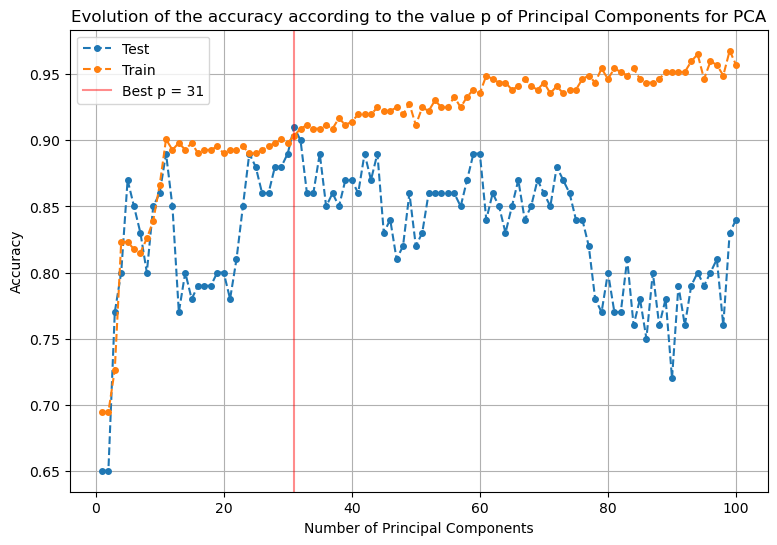

In [28]:
# Plot the validation curve
plt.figure(figsize = [9,6])
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Train accuracy with the best p: 0.91
Train AUC with the best p: 0.97
Test accuracy with the best p: 0.91
Test auc with the best p: 0.94


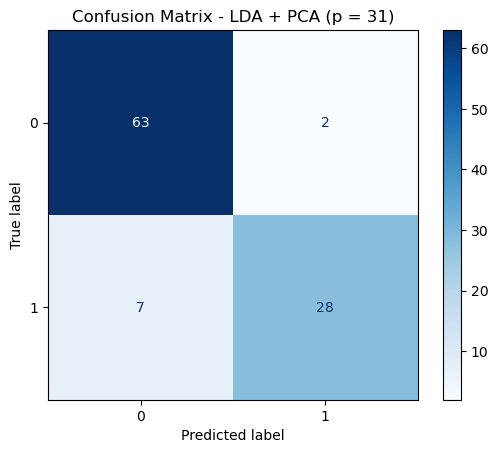

In [30]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X2)

Xp_sst = PCA_sst.transform(X2)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y2, RANDOM_SPLIT = False, train_size = 373, verbose = False)

# Make predictions 
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_test_pred = lda.predict(X_test)
y_train_pred = lda.predict(X_train)

# Compute the scores 
train_accuracy_LDA = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_LDA = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
print(f"Train accuracy with the best p: {train_accuracy_LDA:.2f}")
print(f"Train AUC with the best p: {roc_auc_score_train_LDA:.2f}")

test_accuracy_LDA_2 = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_LDA_2 = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy_LDA_2:.2f}")
print(f"Test auc with the best p: {roc_auc_score_test_LDA_2:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lda.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - LDA + PCA (p = {best_p_value})")
plt.show()

In [108]:
print(test_accuracy_LDA_2, test_accuracy_LDA)

0.91 0.91


## 2. Ridge and Lasso for classification

In [ ]:
# We work with the original data and split it 
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    X2, y2, RANDOM_SPLIT=False, train_size=373
    )

X_train_cv, X_validation, y_train_cv, y_validation = useful_functions.split_scale_data(
    X_train, y_train, RANDOM_SPLIT=False, train_size=300, verbose=False, scale=False
    )

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (373, 64800)
Shape of y_train: (373,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)


### 2.1 Ridge Classification

In [34]:
best_lambda, max_accuracy_validation_Ridge, train_accuracy_Ridge, lambda_values, coefficients, accuracy_train_cv_list, accuracy_valid_list = useful_functions.validation(X_train_cv,
                                                                                           y_train_cv,
                                                                                           X_validation,
                                                                                           y_validation,
                                                                                           low_power=1,
                                                                                           high_power=7,
                                                                                           nb_points=100)


Best parameter value after validation: 4641.6
Accuracy for training: 0.993
Accuracy for validation: 0.877


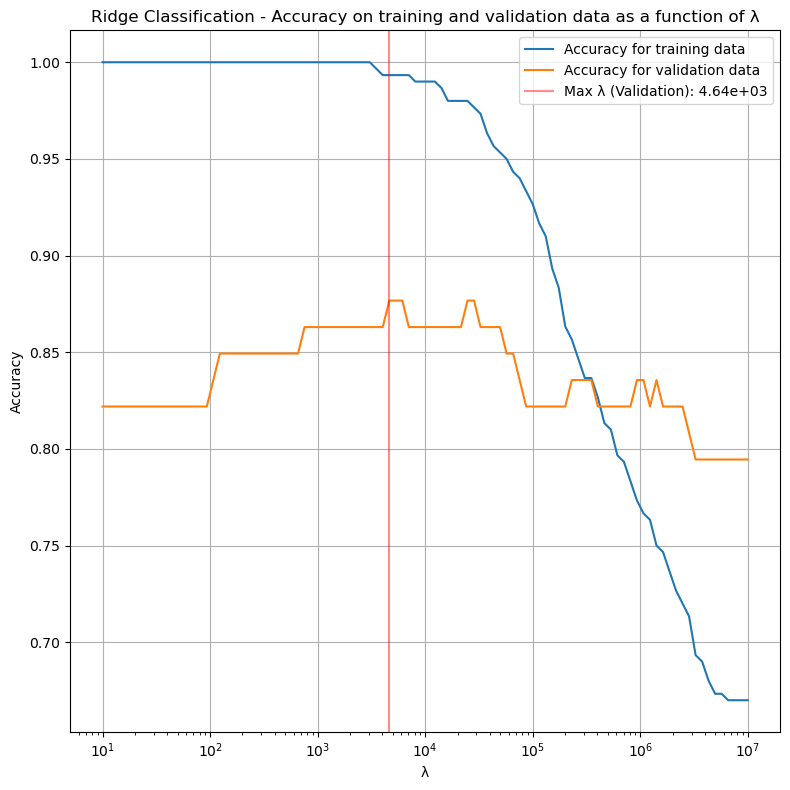

In [35]:
# Plot accuracy and coefficient evolution as a function of lambda
plt.figure(figsize = [8, 8])

# Plot accuracy for training and validation sets
plt.semilogx(lambda_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(lambda_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = best_lambda, color = 'r', linestyle = '-', label = f'Max λ (Validation): {best_lambda:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.title('Ridge Classification - Accuracy on training and validation data as a function of λ')
plt.grid()
plt.tight_layout()
plt.show()

Train accuracy with the best λ: 0.99
Train AUC with the best λ: 1.00
Test accuracy with the best λ: 0.87
Test AUC with the best λ: 0.93


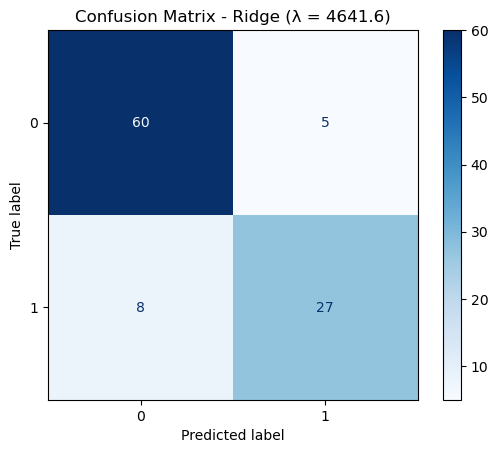

In [37]:
# Evaluate the best Ridge model
ridge = RidgeClassifier(alpha = best_lambda)
ridge.fit(X_train, y_train)

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

# Decision values for AUC computation
train_decision_values = ridge.decision_function(X_train)
test_decision_values = ridge.decision_function(X_test)

# Compute scores
train_accuracy_RIDGE = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_RIDGE = roc_auc_score(y_train, train_decision_values)
print(f"Train accuracy with the best λ: {train_accuracy_RIDGE:.2f}")
print(f"Train AUC with the best λ: {roc_auc_score_train_RIDGE:.2f}")

test_accuracy_RIDGE_2 = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_RIDGE_2 = roc_auc_score(y_test, test_decision_values)
print(f"Test accuracy with the best λ: {test_accuracy_RIDGE_2:.2f}")
print(f"Test AUC with the best λ: {roc_auc_score_test_RIDGE_2:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ridge.classes_)
disp.plot(cmap = 'Blues')
plt.title(f"Confusion Matrix - Ridge (λ = {best_lambda:.1f})")
plt.show()

In [64]:
print(test_accuracy_RIDGE_2, test_accuracy_RIDGE)

0.87 0.91


### 2.2 Lasso Classification

In [39]:
# Define the classifier
lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1.0) 
lasso.fit(X_train, y_train)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {lasso.score(X_train, y_train):.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {lasso.score(X_test, y_test):.3f}")

==== TRAIN ====
Accuracy for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.800


In [40]:
best_C, max_accuracy_validation_Lasso, train_accuracy_Lasso, C_values, coefficients, accuracy_train_cv_list, accuracy_valid_list = useful_functions.validation(X_train_cv,
                                                                                           y_train_cv,
                                                                                           X_validation,
                                                                                           y_validation,
                                                                                           low_power=-3,
                                                                                           high_power=2,
                                                                                           nb_points=50,
                                                                                           Ridge=False)


Best parameter value after validation: 0.6
Accuracy for training: 0.993
Accuracy for validation: 0.877


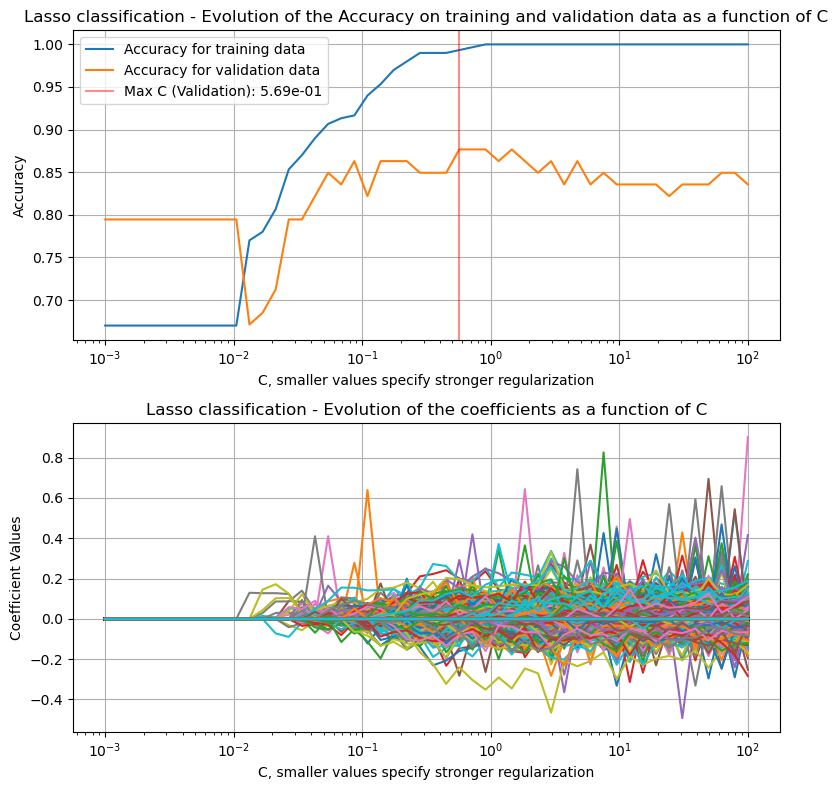

In [41]:
# Plot the results
plt.figure(figsize = [8,8])
plt.subplot(2,1,1)

plt.semilogx(C_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(C_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = best_C, color = 'r', linestyle = '-', label = f'Max C (Validation): {best_C:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Accuracy')
plt.title('Lasso classification - Evolution of the Accuracy on training and validation data as a function of C')
plt.grid()

plt.subplot(2,1,2)
plt.semilogx(C_values, coefficients[:, 0])
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Lasso classification - Evolution of the coefficients as a function of C')

plt.tight_layout() 

Train accuracy with the best λ: 0.99
Train AUC with the best λ: 1.00
Test accuracy with the best λ: 0.80
Test auc with the best λ: 0.90


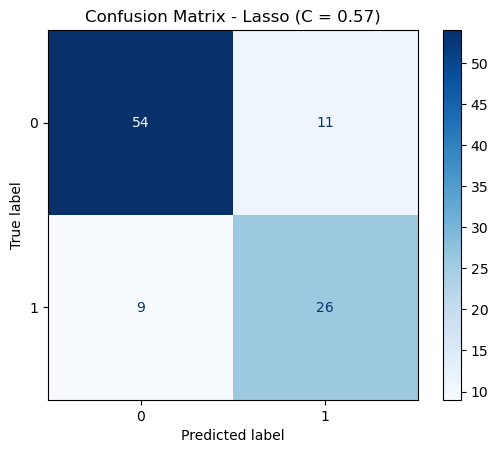

In [42]:
# Evaluate the best Lasso model
lasso = LogisticRegression(penalty='l1', solver='liblinear', C = best_C)
lasso.fit(X_train, y_train)

y_test_pred = lasso.predict(X_test)
y_train_pred = lasso.predict(X_train)

train_decision_values = lasso.decision_function(X_train)
test_decision_values = lasso.decision_function(X_test)

# Compute the scores 
train_accuracy_LASSO = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_LASSO = roc_auc_score(y_train, train_decision_values)
print(f"Train accuracy with the best λ: {train_accuracy_LASSO:.2f}")
print(f"Train AUC with the best λ: {roc_auc_score_train_LASSO:.2f}")

test_accuracy_LASSO_2 = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_LASSO_2 = roc_auc_score(y_test, test_decision_values)
print(f"Test accuracy with the best λ: {test_accuracy_LASSO_2:.2f}")
print(f"Test auc with the best λ: {roc_auc_score_test_LASSO_2:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, lasso.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = lasso.classes_)
disp.plot(cmap = 'Blues')
plt.title(f"Confusion Matrix - Lasso (C = {best_C:.2f})")
plt.show()

In [65]:
print(test_accuracy_LASSO_2, test_accuracy_LASSO)

0.8 0.88


## 3. SVC

In [67]:
# Define PCA for 50 features 
PCA_sst = PCA(n_components = 50)
PCA_sst.fit(X2)

Xp_sst = PCA_sst.transform(X2)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y2, RANDOM_SPLIT = False, train_size = 373, verbose = False)

In [68]:
# param grid for hyper-parameter tuning
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
param_grids = [svc_params]

models = [SVC(probability=True)]
model_names = ["SVC"]

best_model_name = None
best_model = None
best_params = None
best_accuracy = 0
best_auc = 0

models_accuracies = []
models_auc = []

for i in range(len(models)):
    print(f"\nTuning {model_names[i]}")
    grid_search = GridSearchCV(models[i], param_grids[i], scoring = 'accuracy', cv = 5)
    grid_search.fit(X_train, y_train)

    # Best estimator and parameters
    best_estimator = grid_search.best_estimator_
    best_params_model = grid_search.best_params_
    best_accuracy_model = grid_search.best_score_

    # Evaluate on the test set
    y_test_pred = best_estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, best_estimator.predict_proba(X_test)[:, 1])

    print(f"Best Parameters for {model_names[i]}: {best_params_model}")
    print(f"Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")

    models_accuracies.append(test_accuracy)
    models_auc.append(test_auc)

    if test_accuracy > best_accuracy or (test_accuracy == best_accuracy and test_auc > best_auc):
        best_model_name = model_names[i]
        best_model = best_estimator
        best_params = best_params_model
        best_accuracy = test_accuracy
        best_auc = test_auc


Tuning SVC
Best Parameters for SVC: {'C': 1, 'kernel': 'linear'}
Test Accuracy: 0.7600, Test AUC: 0.9367


In [69]:
p_values = np.linspace(1, 50, 50).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []
models_pca = []

for p in p_values:
    PCA_sst = PCA(n_components = p)
    PCA_sst.fit(X2)

    Xp_sst = PCA_sst.transform(X2)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y2, RANDOM_SPLIT = False, train_size = 373, verbose = False)

    # Define the classifier
    model = best_model

    # Fit the model on the data
    model.fit(X_train,y_train)

    # Get the prediction
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred))
    models_pca.append(model)

Best value of p - PCA : 14
Train Score for the best p: 0.9142091152815014
Test Score for the best p: 0.93


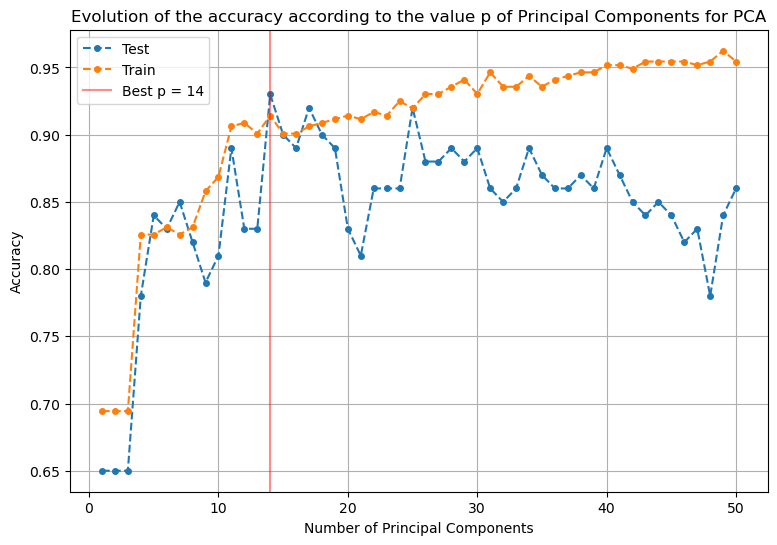

In [70]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]
best_model_pca = models_pca[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")

# Plot the validation curve
plt.figure(figsize = [9,6])
plt.plot(p_values, test_score_accuracy, 'o', markersize = 4, ls = '--', label = "Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize = 4, ls = '--', label = "Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Test accuracy with the best p: 0.90
Test auc with the best p: 0.96
Test accuracy with the best p: 0.92
Test auc with the best p: 0.95


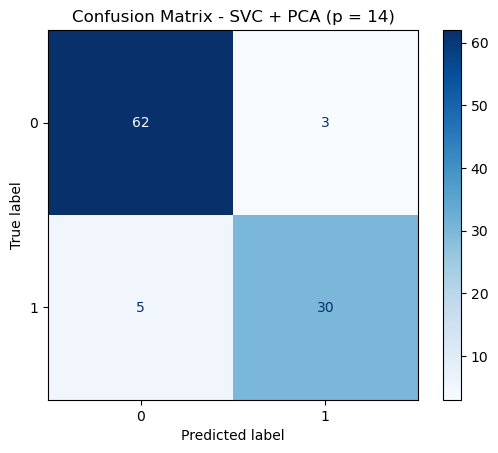

In [79]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X2)

Xp_sst = PCA_sst.transform(X2)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y2, RANDOM_SPLIT = False, train_size = 373, verbose = False
)
best_model_pca.fit(X_train, y_train)

# Make predictions 
y_test_pred = best_model_pca.predict(X_test)
y_train_pred = best_model_pca.predict(X_train)

# Print the scores
train_accuracy_SVC = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_SVC = roc_auc_score(y_train, best_model_pca.predict_proba(X_train)[:, 1])
print(f"Test accuracy with the best p: {train_accuracy_SVC:.2f}")
print(f"Test auc with the best p: {roc_auc_score_train_SVC:.2f}")

test_accuracy_SVC_2 = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_SVC_2 = roc_auc_score(y_test, best_model_pca.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy_SVC_2:.2f}")
print(f"Test auc with the best p: {roc_auc_score_test_SVC_2:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = best_model_pca.classes_)
disp.plot(cmap = 'Blues')
plt.title(f"Confusion Matrix - SVC + PCA (p = {best_p_value})")
plt.show()

In [78]:
print(test_accuracy_SVC_2, test_accuracy_SVC)

0.89 0.89


## 4. Neural Networks

In [93]:
# Define PCA for 50 features 
PCA_sst = PCA(n_components = 50)
PCA_sst.fit(X2)

Xp_sst = PCA_sst.transform(X2)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y2, RANDOM_SPLIT = False, train_size = 373, verbose = False
    )

In [94]:
param_grid = {
    'hidden_layer_sizes': [
        (128,),              
        (128, 64),           
        (128, 64, 32),       
        (256, 128, 64),      
    ],
    'alpha': [1e-4, 1e-3, 1e-2],  
    'solver': ['adam'],           
    'max_iter': [200],            
}

mlp = MLPClassifier(random_state = 42, early_stopping = True, validation_fraction = 0.2)

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
grid_search = GridSearchCV(estimator=mlp, param_grid = param_grid, scoring = 'accuracy', cv = cv)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validated accuracy: {grid_search.best_score_:.3f}")

Best parameters found: {'alpha': 0.0001, 'hidden_layer_sizes': (128, 64, 32), 'max_iter': 200, 'solver': 'adam'}
Best cross-validated accuracy: 0.885


In [95]:
# Validation curve with different values of p for the MLP model
p_values = np.linspace(1, 50, 50).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []
models_pca = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components=p)
    PCA_sst.fit(X2)

    # Project data
    Xp_sst = PCA_sst.transform(X2)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
        Xp_sst, y2, RANDOM_SPLIT = False, train_size = 373, verbose = False
        )

    # Define the classifier
    model = grid_search.best_estimator_

    # Fit the model on the data
    model.fit(X_train,y_train)

    # Get the prediction
    y_test_pred= model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred))
    models_pca.append(model)


Best value of p - PCA : 9
Train Score for the best p: 0.8605898123324397
Test Score for the best p: 0.86


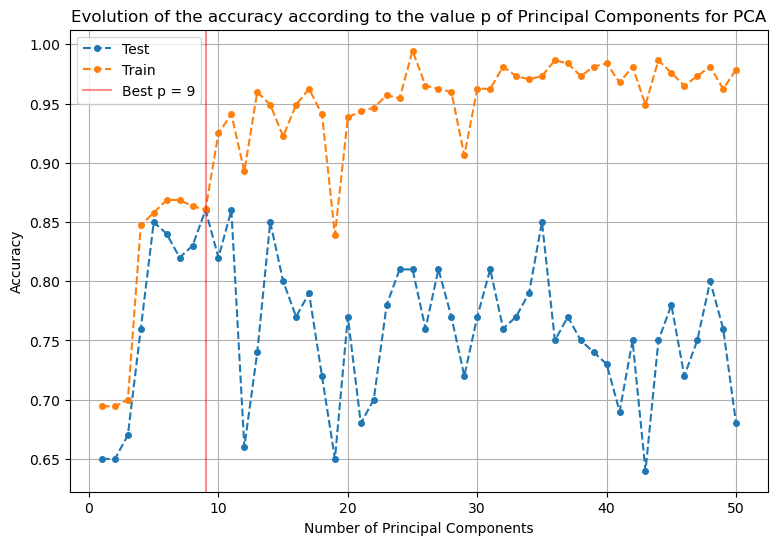

In [96]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]
best_model_pca = models_pca[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")

# Plot the validation curve
plt.figure(figsize = [9,6])
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Test accuracy with the best p: 0.80
Test auc with the best p: 0.92
Test accuracy with the best p: 0.78
Test auc with the best p: 0.93


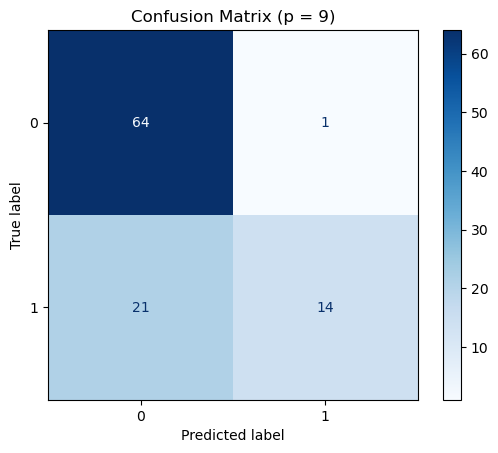

In [97]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X2)

Xp_sst = PCA_sst.transform(X2)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y2, RANDOM_SPLIT = False, train_size = 373, verbose = False
)
best_model_pca.fit(X_train, y_train)

# Make predictions 
y_test_pred = best_model_pca.predict(X_test)
y_train_pred = best_model_pca.predict(X_train)

# Print the scores
train_accuracy_MLP = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_MLP = roc_auc_score(y_train, best_model_pca.predict_proba(X_train)[:, 1])
print(f"Test accuracy with the best p: {train_accuracy_MLP:.2f}")
print(f"Test auc with the best p: {roc_auc_score_train_MLP:.2f}")

# Print the scores
test_accuracy_MLP_2 = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_MLP_2 = roc_auc_score(y_test, best_model_pca.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy_MLP_2:.2f}")
print(f"Test auc with the best p: {roc_auc_score_test_MLP_2:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = best_model_pca.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (p = {best_p_value})")
plt.show()

In [98]:
print(test_accuracy_MLP_2, test_accuracy_MLP)

0.78 0.83


## 5. Recap of the models

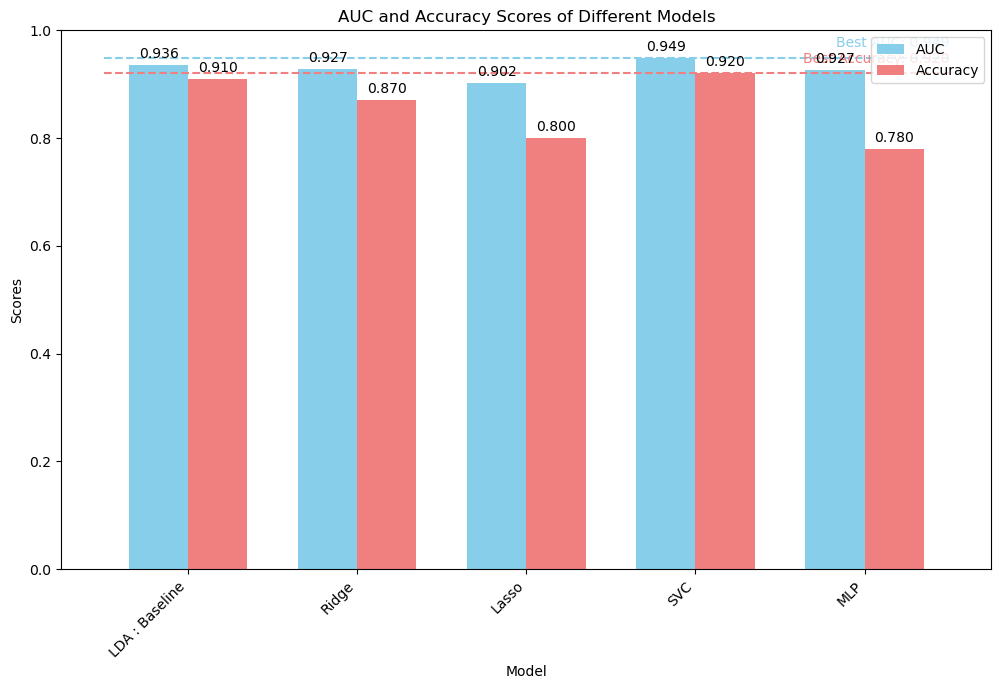

In [99]:
model_names = ["LDA : Baseline", "Ridge", "Lasso", "SVC", "MLP"]
models_accuracies = [test_accuracy_LDA_2, test_accuracy_RIDGE_2, test_accuracy_LASSO_2, test_accuracy_SVC_2, test_accuracy_MLP_2]
models_auc = [roc_auc_score_test_LDA_2, roc_auc_score_test_RIDGE_2, roc_auc_score_test_LASSO_2, roc_auc_score_test_SVC_2, roc_auc_score_test_MLP_2]
plot_score(model_names, models_auc, models_accuracies)

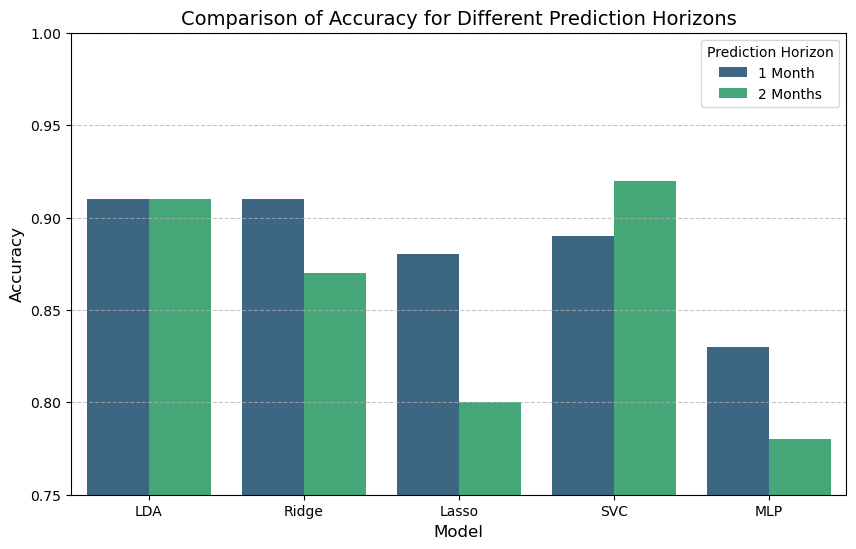

In [111]:
data = {
    'Model': ['LDA', 'Ridge', 'Lasso', 'SVC', 'MLP'],
    'Accuracy_1_month': [test_accuracy_LDA, test_accuracy_RIDGE, test_accuracy_LASSO, test_accuracy_SVC, test_accuracy_MLP],
    'Accuracy_2_months': [test_accuracy_LDA_2, test_accuracy_RIDGE_2, test_accuracy_LASSO_2, test_accuracy_SVC_2, test_accuracy_MLP_2]
}

# Créer un DataFrame
accuracy_df = pd.DataFrame(data)

# Reshape the data
accuracy_melted = pd.melt(accuracy_df, id_vars=['Model'], 
                          value_vars=['Accuracy_1_month', 'Accuracy_2_months'],
                          var_name='Prediction_Horizon', value_name='Accuracy')
accuracy_melted['Prediction_Horizon'] = accuracy_melted['Prediction_Horizon'].replace({
    'Accuracy_1_month': '1 Month',
    'Accuracy_2_months': '2 Months'
})

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=accuracy_melted, x='Model', y='Accuracy', hue='Prediction_Horizon', palette='viridis')
plt.title('Comparison of Accuracy for Different Prediction Horizons', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0.75, 1.0)
plt.legend(title='Prediction Horizon', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Predictions for more months

In [ ]:
def get_pred_SVC(list_number_months):
    # Initialize output
    list_test_accuracy_SVC = []
    list_test_roc_auc_SVC = []

    for N in list_number_months:
        print(f"#################### {N}-months prediction ####################")
        # Get the data for a N-month prediction, split and scale the data
        X, y = useful_functions.get_data(f"data/preprocessed_data/nino_dataset_{N}m.npz")

        ############################# Tune SVC
        print('######### Tune SVC ...')
        # Define PCA for 50 features 
        PCA_sst = PCA(n_components = 50)
        PCA_sst.fit(X)

        Xp_sst = PCA_sst.transform(X)
        X_train, X_test, y_train, y_test= useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374 - (N-1), verbose=False)
        # param grid for hyper-parameter tuning
        svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
        param_grids = [svc_params]

        models = [SVC(probability=True)]
        model_names = ["SVC"]

        best_model_name = None
        best_model = None
        best_params = None
        best_accuracy = 0
        best_auc = 0

        models_accuracies = []
        models_auc = []

        for i in range(len(models)):
            print(f"\nTuning {model_names[i]}")
            grid_search = GridSearchCV(models[i], param_grids[i], scoring = 'accuracy', cv = 5)
            grid_search.fit(X_train, y_train)

            # Best estimator and parameters
            best_estimator = grid_search.best_estimator_
            best_params_model = grid_search.best_params_
            best_accuracy_model = grid_search.best_score_

            # Evaluate on the test set
            y_test_pred = best_estimator.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            test_auc = roc_auc_score(y_test, best_estimator.predict_proba(X_test)[:, 1])

            print(f"Best Parameters for {model_names[i]}: {best_params_model}")
            print(f"Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")

            models_accuracies.append(test_accuracy)
            models_auc.append(test_auc)

            if test_accuracy > best_accuracy or (test_accuracy == best_accuracy and test_auc > best_auc):
                best_model_name = model_names[i]
                best_model = best_estimator
                best_params = best_params_model
                best_accuracy = test_accuracy
                best_auc = test_auc
        p_values = np.linspace(1, 50, 50).astype(int)
        p_values = p_values.astype(int)
        test_score_accuracy = []
        train_score_accuracy = []
        models_pca = []

        ############################# Tune PCA
        print('######### Tune PCA ...')
        for p in p_values:
            PCA_sst = PCA(n_components = p)
            PCA_sst.fit(X)

            Xp_sst = PCA_sst.transform(X)
            X_train, X_test, y_train, y_test= useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374 - (N-1), verbose=False)

            # Define the classifier
            model = best_model

            # Fit the model on the data
            model.fit(X_train,y_train)

            # Get the prediction
            y_test_pred = model.predict(X_test)
            y_train_pred = model.predict(X_train)

            # Computation of the accuracy
            test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
            train_score_accuracy.append(accuracy_score(y_train, y_train_pred))
            models_pca.append(model)
        # Get the best score
        best_index = np.argsort(-np.array(test_score_accuracy))[0]
        best_p_value = p_values[best_index]
        best_test_score_pca = test_score_accuracy[best_index]
        best_train_score_pca = train_score_accuracy[best_index]
        best_model_pca = models_pca[best_index]

        # Prints
        print(f"Best value of p - PCA : {best_p_value}")
        print(f"Train Score for the best p: {best_train_score_pca}")
        print(f"Test Score for the best p: {best_test_score_pca}")

        ############################# TEST
        print('######### TEST ...')
        # PCA with the best value of p
        PCA_sst = PCA(n_components = best_p_value)
        PCA_sst.fit(X)

        Xp_sst = PCA_sst.transform(X)
        X_train, X_test, y_train, y_test= useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374 - (N-1), verbose=False)

        best_model_pca.fit(X_train, y_train)

        # Make predictions 
        y_test_pred = best_model_pca.predict(X_test)
        y_train_pred = best_model_pca.predict(X_train)

        # Print and get the outputs
        test_accuracy_SVC = accuracy_score(y_test, y_test_pred)
        list_test_accuracy_SVC.append(test_accuracy_SVC)
        roc_auc_score_test_SVC = roc_auc_score(y_test, best_model_pca.predict_proba(X_test)[:, 1])
        list_test_roc_auc_SVC.append(roc_auc_score_test_SVC)
        print(f"Test accuracy with the best p: {test_accuracy_SVC:.2f}")
        print(f"Test auc with the best p: {roc_auc_score_test_SVC:.2f}")
        
    return list_test_accuracy_SVC, list_test_roc_auc_SVC

In [158]:
list_test_accuracy_SVC, list_test_roc_auc_SVC = get_pred_SVC(list_number_months=[i for i in range(1,13)])

#################### 1-months prediction ####################
==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
######### Tune SVC ...

Tuning SVC
Best Parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.8600, Test AUC: 0.9354
######### Tune PCA ...
Best value of p - PCA : 5
Train Score for the best p: 0.9197860962566845
Test Score for the best p: 0.87
######### TEST ...
Test accuracy with the best p: 0.87
Test auc with the best p: 0.95
#################### 2-months prediction ####################
==== GET THE DATA ====
Shape of X: (473, 64800)
Shape of y: (473,)
First 25 elements of y: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
######### Tune SVC ...

Tuning SVC
Best Parameters for SVC: {'C': 10, 'kernel': 'linear'}
Test Accuracy: 0.7300, Test AUC: 0.9156
######### Tune PCA ...
Best value of p - PCA : 16
Train Score for the best p: 0.9115281501340483
Test Score for the bes

In [152]:
def get_pred_LDA(list_number_months):
    # Initialize output
    list_test_accuracy_LDA = []
    list_test_roc_auc_LDA = []

    for N in list_number_months:
        print(f"#################### {N}-months prediction ####################")
        # Get the data for a N-month prediction, split and scale the data
        X, y = useful_functions.get_data(f"data/preprocessed_data/nino_dataset_{N}m.npz")

        ############################# Tune PCA
        print('######### Tune PCA ...')
        # Perform several LDA with different value of p to get a validation curve for this parameter
        p_values = np.linspace(1, 100, 100).astype(int)
        p_values = p_values.astype(int)
        test_score_accuracy = []
        train_score_accuracy = []

        for p in p_values:
            # PCA with p principal components
            PCA_sst = PCA(n_components = p)
            PCA_sst.fit(X)

            # Project data
            Xp_sst = PCA_sst.transform(X)
            X_train, X_test, y_train, y_test= useful_functions.split_scale_data(
                Xp_sst, y, RANDOM_SPLIT = False,
                train_size = 374 - (N-1), verbose=False
                )


            # Define the classifier
            lda = LinearDiscriminantAnalysis()

            # Fit the model on the data
            lda.fit(X_train,y_train)

            # Get the prediction
            y_test_pred= lda.predict(X_test)
            y_train_pred= lda.predict(X_train)

            # Computation of the accuracy
            test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
            train_score_accuracy.append(accuracy_score(y_train, y_train_pred))

        # Get the best score
        best_index = np.argsort(-np.array(test_score_accuracy))[0]
        best_p_value = p_values[best_index]
        best_test_score_pca = test_score_accuracy[best_index]
        best_train_score_pca = train_score_accuracy[best_index]

        ############################# TEST
        print('######### TEST ...')
        # PCA with the best value of p
        PCA_sst = PCA(n_components = best_p_value)
        PCA_sst.fit(X)

        Xp_sst = PCA_sst.transform(X)
        X_train, X_test, y_train, y_test= useful_functions.split_scale_data(
                    Xp_sst, y, RANDOM_SPLIT = False,
                    train_size = 374 - (N-1), verbose=False
                    )
        # Make predictions 
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train, y_train)
        y_test_pred = lda.predict(X_test)
        y_train_pred = lda.predict(X_train)

        test_accuracy_LDA = accuracy_score(y_test, y_test_pred)
        list_test_accuracy_LDA.append(test_accuracy_LDA)
        roc_auc_score_test_LDA = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
        list_test_roc_auc_LDA.append(roc_auc_score_test_LDA)
        print(f"Test accuracy with the best p: {test_accuracy_LDA_3:.2f}")
        print(f"Test auc with the best p: {roc_auc_score_test_LDA_3:.2f}")

    return list_test_accuracy_LDA, list_test_roc_auc_LDA


In [155]:
list_test_accuracy_LDA, list_test_roc_auc_LDA = get_pred_LDA(list_number_months=[i for i in range(1,13)])

#################### 1-months prediction ####################
==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
######### Tune PCA ...
######### TEST ...
Test accuracy with the best p: 0.88
Test auc with the best p: 0.95
#################### 2-months prediction ####################
==== GET THE DATA ====
Shape of X: (473, 64800)
Shape of y: (473,)
First 25 elements of y: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
######### Tune PCA ...
######### TEST ...
Test accuracy with the best p: 0.88
Test auc with the best p: 0.95
#################### 3-months prediction ####################
==== GET THE DATA ====
Shape of X: (472, 64800)
Shape of y: (472,)
First 25 elements of y: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
######### Tune PCA ...
######### TEST ...
Test accuracy with the best p: 0.88
Test auc with the best p: 0.95
#################### 4-months prediction #################

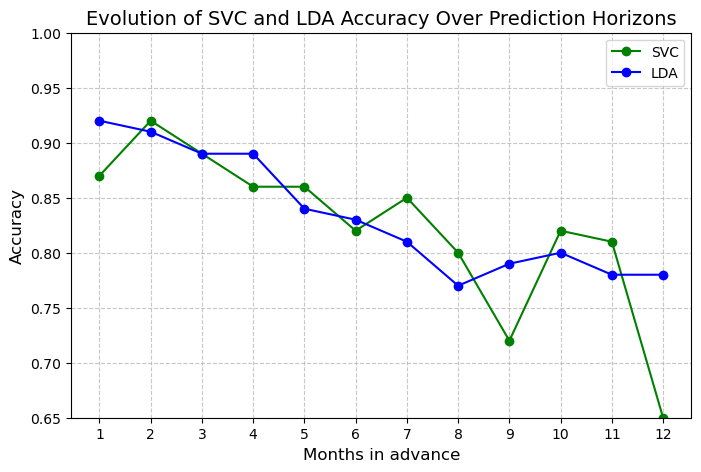

In [161]:
# Plot the evolution of accuracy
N = [i for i in range(1,13)]
plt.figure(figsize=(8, 5))
plt.plot(N, list_test_accuracy_SVC, marker='o', color='green', label='SVC')
plt.plot(N, list_test_accuracy_LDA, marker='o', color='blue', label='LDA')


# Add details to the plot
plt.title('Evolution of SVC and LDA Accuracy Over Prediction Horizons', fontsize=14)
plt.xlabel('Months in advance', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(N)
plt.ylim(min(list_test_accuracy_SVC), 1.0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)